# Initializing 

In [1]:
import time 

# Misc 
start = time.time()
outputDirectory = '/home/user1/Dropbox/Research/Neurobiology_PhD/Rotations/Brunel/Code/Personal/brian2cuda/CUBA_CUDA_sp'

In [2]:
%config Completer.use_jedi = False 

/home/user1/.pyenv/versions/2.7.18/envs/py2_brianBrunel/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [3]:
import matplotlib
matplotlib.use('Agg')

%matplotlib inline

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 

In [5]:
from brian2 import *
import brian2cuda

set_device('cuda_standalone', directory=outputDirectory,compile=True, run=True, debug=True, clean=True)

#### Personal Functions 

In [6]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [7]:
def plot_spikes(monitor, stateMonitor, rangeNeurons):
    for i in range(rangeNeurons):
        spikes = (monitor.t[monitor.i == i] - defaultclock.dt)/ms
        val = stateMonitor[i].V
        subplot(rangeNeurons, 1, i+1)
        plot(tile(spikes, (2, 1)), vstack((val[array(spikes, dtype=int)], zeros(len(spikes)))), 'C0')
        title("Spikes")
    tight_layout()
    show()

In [8]:
def plot_potential(monitor, stateMonitor, rangeNeurons):
    for i in range(rangeNeurons):
        spikes = (monitor.t[monitor.i == i] - defaultclock.dt)/ms
        val = stateMonitor[i].V
        subplot(rangeNeurons, 1, i+1)
        plot(stateMonitor.t/ms, val)
        title("Trace")
    tight_layout()
    show()

In [9]:
def plot_population(prMonitorRun, spikeMonitorRun, labelGroup, nActivity, pRun): 
    # plotting
    title('Population rates')
    xlabel('ms')
    ylabel('Hz')

    plot(prMonitorRun.t / ms, prMonitorRun.smooth_rate(width=25 * ms) / Hz, label=labelGroup)

    legend()
    figure()

    title('Population activities ({} neurons/pop)'.format(nActivity))
    xlabel('ms')
    yticks([])

    plot(spikeMonitorRun.t / ms, spikeMonitorRun.i + (pRun + 1) * nActivity, '.', markersize=2, label=labelGroup) 


    legend()
    show()

In [10]:
def plot_population_Multi(prMonitorRun_smooth, prMonitorRun_t, spikeMonitorRun, labelGroup, nActivity, pRun): 
    # plotting
    title('Population rates')
    xlabel('ms')
    ylabel('Hz')

    plot(prMonitorRun_t / ms, prMonitorRun_smooth, label=labelGroup)

    legend()
    figure()

    title('Population activities ({} neurons/pop)'.format(nActivity))
    xlabel('ms')
    yticks([])

    plot(spikeMonitorRun.t / ms, spikeMonitorRun.i + (pRun + 1) * nActivity, '.', markersize=2, label=labelGroup) 

    legend()
    show()

In [11]:
def plot_population_Multi_2(prMonitorRun_smooth, prMonitorRun_t, labelGroup): 
    # plotting
    title('Population rates')
    xlabel('ms')
    ylabel('Hz')

    plot(prMonitorRun_t / ms, prMonitorRun_smooth, label=labelGroup)

    legend()
    show()

In [12]:
def active_percent(monitor, binSize, durationSimulation, numNeurons, ymax):
    # Define bin size 
    bin_size = binSize*ms
    # Define duration of simulation 
    duration = durationSimulation*second
    # Define number of neurons 
    num_Neurons = numNeurons

    # Initialize array to record spike occurancces 
    spkTotal = np.zeros([int(duration/bin_size)])
    
    for current in range(num_Neurons): 
        spk_count, bin_edges = np.histogram(a = np.r_[monitor.t[monitor.i == current]/second],
                                            bins = int(duration/bin_size), range = (0,durationSimulation))
        # Convert spike count to binary 
        binary = np.where(spk_count > 0, 1, 0)
        # Add to recording array
        spkTotal = spkTotal + binary

    plt.plot(bin_edges[:-1], (spkTotal/num_Neurons)*100)
    plt.axis([0, durationSimulation, 0, ymax])
    plt.title('Percent active granule cells as function of time')
    plt.ylabel('Active Cell (%)')
    plt.xlabel('Time (s)')
    plt.show()

In [13]:
def averaged_ActivePercent(spkMulti, spkSingle, binSize, durationSimulation, numNeurons, ymax):
    # Define bin size 
    bin_size = binSize*ms
    # Define duration of simulation 
    duration = durationSimulation*second
    # Define number of neurons 
    num_Neurons = numNeurons
    
    spk_count, bin_edges = np.histogram(a = np.r_[spkSingle.t[spkSingle.i == 1]/second],
                                        bins = int(duration/bin_size), range = (0,durationSimulation))

    averaged_spkMulti = np.mean(spkMulti, axis = 0)
    
    plt.plot(bin_edges[:-1], averaged_spkMulti)
    plt.axis([0, durationSimulation, 0, ymax])
    plt.title('Percent active granule cells as function of time')
    plt.ylabel('Active Cell (%)')
    plt.xlabel('Time (s)')
    plt.show()

#### General paramaters 

In [14]:
# spatial 
#gC = 320
gC = 10
numGC = gC**2 
gG = 32 
#numGolgi = gG**2  
numGolgi = 10 
gGlo = 31
numGlomeruli = gGlo**2

# Spatial paramaters 
gcSpacing = ((gG*(gG-1))/(gC-1))*umetre 
golgiSpacing = 32*umetre 

gcSpacing = ((gG*(gG-1))/(gC-1))*umetre 

# Neuron Models

#### Granule Cells 

In [15]:
# Parameters 

# neuron parameters
theta_GR = -35*mV # threshold (from Yamazaki) 
Cm_GR = 3.1*pF 

# Conductances 
gL_GR = 0.43*nS 
g_AMPA_GR = 0.18*nS 
g_NMDA_GR = 0.025*nS 
g_Inh_GR = 0.028*nS 
g_Ahp_GR = 1*nS

# Various leaks (from Yamazaki) 
El_GR = -58*mV
Eexc = 0*mV 
E_inh_GR = -82*mV 
E_ahp_GR = -82*mV # after hyperpolarization 

# Tau
tau_ahp_GR = 5*ms 
tau_AMPA_GR = 1.2*ms 
tau_NMDA_GR = 52.0*ms 
tau_GABA_1_GR = 7*ms
tau_GABA_2_GR = 59*ms

eqs_GR = Equations('''
                        dV / dt = (-gL_GR * (V - El_GR) - I_syn) / Cm_GR : volt (unless refractory)
                        
                        I_syn = I_AMPA + I_NMDA + I_GABA_tot : amp 
                        I_GABA_tot = 0.43*I_GABA_1 + 0.57*I_GABA_2 : amp 
                        
                        I_AMPA = g_AMPA_GR * (V - Eexc) * s_AMPA : amp
                        ds_AMPA / dt = -s_AMPA / tau_AMPA_GR : 1 
                        
                        I_NMDA = g_NMDA_GR * (V - Eexc) * s_NMDA : amp
                        ds_NMDA / dt = -s_NMDA / tau_NMDA_GR : 1 
                        
                        I_GABA_1 = g_Inh_GR * (V - E_inh_GR) * s_GABA_1 : amp
                        ds_GABA_1 / dt = -s_GABA_1 / tau_GABA_1_GR : 1 
                        
                        I_GABA_2 = g_Inh_GR * (V - E_inh_GR) * s_GABA_2 : amp
                        ds_GABA_2 / dt = -s_GABA_2 / tau_GABA_2_GR : 1 
                        
                        x : metre 
                        y : metre 
                ''')

# Defining granule cell neuron group 
granuleCells = NeuronGroup(N=numGC, model=eqs_GR, reset='V = El_GR',
                    threshold='V > theta_GR',
                    refractory=2*ms, method='euler')
granuleCells.V = El_GR 

In [16]:
granuleCells

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')

In [17]:
# Defining MF input 

# Defining input parameters 
num_inputs = 100
f = 0.5*Hz 
eq_rate = '(22.5 + 7.5*cos((2*pi*t*f) + pi))*Hz'

# Equations 
eqs_glut_MFGR = '''
               w_MFGR : 1 
               '''
eqs_pre_glut_MFGR = '''
               s_AMPA += w_MFGR
               s_NMDA += w_MFGR
               '''

P_MFGR = PoissonGroup(num_inputs, rates = eq_rate)
S_MFGR = Synapses(P_MFGR, granuleCells, model = eqs_glut_MFGR, on_pre = eqs_pre_glut_MFGR, method = 'euler') 
S_MFGR.connect(condition = 'i == j')
S_MFGR.w_MFGR = 4



In [18]:
# Visualize synaptic connections 
# visualise_connectivity(S_MFGR)

#### Golgi

In [19]:
# Parameters 

# neuron parameters
theta_GO = -52*mV # threshold (from Yamazaki) 
Cm_GO = 28.0*pF 

# Conductances 
gL_GO = 2.3*nS 
g_AMPA_GO = 45.5*nS 
g_NMDA_GO = 30.0*nS 
g_Ahp_GO = 20*nS

El_GO = -55*mV
Eexc = 0*mV 
E_ahp_GO = -72.7*mV # after hyperpolarization 

# Tau
tau_ahp_GO = 5*ms 
tau_AMPA_GO = 1.5*ms 
tau_NMDA_1_GO = 31.0*ms 
tau_NMDA_2_GO = 170.0*ms 

eqs_GO = Equations('''
                        dV / dt = (-gL_GO * (V - El_GO) - I_syn) / Cm_GO : volt (unless refractory)
                        
                        I_syn = I_AMPA + I_NMDA_tot : amp 
                        I_NMDA_tot = 0.33*I_NMDA_1 + 0.67*I_NMDA_2 : amp
                        
                        I_AMPA = g_AMPA_GR * (V - Eexc) * s_AMPA : amp
                        ds_AMPA / dt = -s_AMPA / tau_AMPA_GO : 1 
                        
                        I_NMDA_1 = g_NMDA_GO * (V - Eexc) * s_NMDA_1 : amp
                        ds_NMDA_1 / dt = -s_NMDA_1 / tau_NMDA_1_GO : 1 
                        
                        I_NMDA_2 = g_NMDA_GO * (V - Eexc) * s_NMDA_2 : amp
                        ds_NMDA_2 / dt = -s_NMDA_2 / tau_NMDA_2_GO : 1 
                        
                        x : metre 
                        y : metre 
                ''')

# Defining granule cell neuron group 
golgi = NeuronGroup(N=numGolgi, model=eqs_GO, reset='V = El_GO',
                    threshold='V > theta_GO',
                    refractory=5*ms, method='euler')
golgi.V = El_GO 

In [20]:
#golgi

#  Establishing Connectivity 

#### Paramaters 

In [21]:
# Connection probability 
pr_GRGO = 0.0245
#pr_GOGR = 0.025
pr_GOGR = 0.08

#### Granule --> Golgi

In [22]:
# Equations 
eqs_glut_GRGO = '''
               w_GRGO : 1 
               '''
eqs_pre_glut_GRGO = '''
               s_AMPA += 1
               s_NMDA_1 += 1
               s_NMDA_2 += 1 
               '''

In [23]:
# Forming synapses 
S_GRGO = Synapses(granuleCells, golgi, model = eqs_glut_GRGO, on_pre = eqs_pre_glut_GRGO, method = 'euler') 
S_GRGO.connect(p = pr_GRGO)

In [24]:
#visualise_connectivity(S_GRGO)

#### Golgi --> Granule Cells 

In [25]:
# Equations 
eqs_GABA_GOGR = '''
               w_GOGR : 1 
               '''
eqs_pre_GABA_GOGR = '''
               s_GABA_1 += 1
               s_GABA_2 += 1 
               '''

In [26]:
# Forming synapses 
S_GOGR = Synapses(golgi, granuleCells, model = eqs_GABA_GOGR, on_pre = eqs_pre_GABA_GOGR, method = 'euler') 
#S_GOGR.connect(condition = 'abs(i-j)<2')
S_GOGR.connect(p = pr_GOGR)

In [27]:
#visualise_connectivity(S_GOGR)

# Running simulation 

In [28]:
def spk_active(monitor, binSize, durationSimulation, numNeurons): 
    # Define bin size 
    bin_size = binSize*ms
    # Define duration of simulation 
    duration = durationSimulation*second
    # Define number of neurons 
    num_Neurons = numNeurons

    # Initialize array to record spike occurancces 
    spkTotal = np.zeros([int(duration/bin_size)])
    
    for current in range(num_Neurons): 
        spk_count, bin_edges = np.histogram(a = np.r_[monitor.t[monitor.i == current]/second],
                                            bins = int(duration/bin_size), range = (0,2))
        # Convert spike count to binary 
        binary = np.where(spk_count > 0, 1, 0)
        # Add to recording array
        spkTotal = spkTotal + binary
    
    return((spkTotal/num_Neurons)*100)

In [29]:
# Setting up monitors

# Granule Cell 
spikeMonitor_GR = SpikeMonitor(granuleCells)
stateMonitor_GR = StateMonitor(granuleCells, 'V', record=True)
prMonitor_GR = PopulationRateMonitor(granuleCells)

# Golgi cells  
spikeMonitor_GO = SpikeMonitor(golgi)
stateMonitor_GO = StateMonitor(golgi, 'V', record=True)
prMonitor_GO = PopulationRateMonitor(golgi)

In [30]:
# run the simulation
BrianLogger.log_level_info()
run(20*second, report = 'stdout', profile = True)

('debug syn effect mode ', 'target')
('debug syn effect mode ', 'target')
('debug syn effect mode ', 'target')
INFO _last_run_time = 36.2971 s


#### Benchmarking 

In [31]:
time.time() - start 

69.42364692687988

In [32]:
# For benchmarking time usage per step ... do not use with multiple runs 
profiling_summary(show = 10)

statemonitor_codeobject,3.20 s,9.97 %
statemonitor_1_codeobject,3.12 s,9.71 %
neurongroup_stateupdater_codeobject,2.17 s,6.78 %
poissongroup_thresholder_codeobject,2.01 s,6.27 %
synapses_pre_codeobject,1.93 s,6.02 %
neurongroup_1_stateupdater_codeobject,1.92 s,5.98 %
synapses_2_pre_codeobject,1.85 s,5.76 %
neurongroup_1_thresholder_codeobject,1.84 s,5.72 %
neurongroup_thresholder_codeobject,1.81 s,5.65 %
synapses_1_pre_codeobject,1.79 s,5.58 %


# Visualization 

#### Splitting into runs 

In [ ]:
# Granule cell array 
spikeMonitor_Multi_GR = []
spkActive_Multi_GR = []
# Population 
populationRates_GR = []
prMulti_GR_smooth = []
prMulti_GR_t = []

# Purkinje array 
prMulti_PKJ_smooth = []
prMulti_PKJ_t = []

# Basket cell array 
prMulti_BS_smooth = []
prMulti_BS_t = []

# Golgi array 
prMulti_GO_smooth = []
prMulti_GO_t = []

### Individial Cells 

In [ ]:
plot_potential(spikeMonitor_GR, stateMonitor_GR, 2)

In [ ]:
plot_spikes(spikeMonitor_GR, stateMonitor_GR, 2)

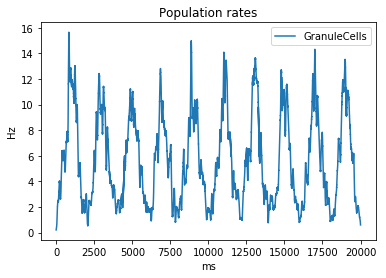

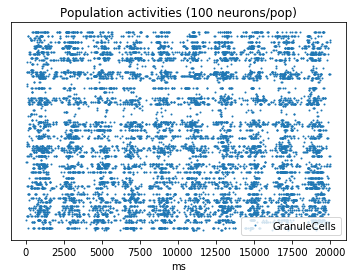

In [33]:
plot_population(prMonitor_GR, spikeMonitor_GR, 'GranuleCells', 100, 10)

In [ ]:
plot_population_Multi(prMulti_GR_smooth[0], prMulti_GR_t[0], spikeMonitor_GR, 'GranuleCells', 10, 10)

In [ ]:
plot_population_Multi(prMulti_GR_smooth[1], prMulti_GR_t[1], spikeMonitor_GR, 'GranuleCells', 10, 10)

In [ ]:
tempAppend = []
neuronNumber = 0

for i in range(len(spikeMonitor_Multi_GR)):
    tempAppend.extend(pd.array(spikeMonitor_Multi_GR[i][neuronNumber])*1000)

sns.kdeplot(tempAppend, bw_adjust = 0.5)

In [ ]:
tempAppend = []
neuronNumber = 1

for i in range(len(spikeMonitor_Multi_GR)):
    tempAppend.extend(pd.array(spikeMonitor_Multi_GR[i][neuronNumber])*1000)

sns.kdeplot(tempAppend, bw_adjust = 0.2)

In [ ]:
tempAppend = []
neuronNumber = 2

for i in range(len(spikeMonitor_Multi_GR)):
    tempAppend.extend(pd.array(spikeMonitor_Multi_GR[i][neuronNumber])*1000)

sns.kdeplot(tempAppend, bw_adjust = 0.2)

In [ ]:
tempAppend = []
neuronNumber = 19

for i in range(len(spikeMonitor_Multi_GR)):
    tempAppend.extend(pd.array(spikeMonitor_Multi_GR[i][neuronNumber])*1000)

sns.kdeplot(tempAppend, bw_adjust = 0.1)

#### Population Readouts

In [ ]:
# Plotting average population firing rate across all runs 
average_prMulti = np.mean(prMulti_GR_smooth, axis = 0)

plot_population_Multi_2(average_prMulti, prMulti_GR_t[1], 'GranuleCells')

In [ ]:
active_percent(spikeMonitor_GR, binSize = 10, durationSimulation = 2, numNeurons = numGC, ymax = 20)

In [ ]:
averaged_ActivePercent(spkActive_Multi_GR, spikeMonitor_GR, binSize = 10, durationSimulation = 2, numNeurons = numGC, ymax = 15)